All imports in one place for better redability.

In [16]:
import torch
from torch.utils.data import Dataset, DataLoader
import tiktoken
import torch.nn as nn

Custom PyTorch Dataset for GPT-style language modeling.
This class takes a large text, tokenizes it, and splits it into overlapping input-target sequence pairs using a sliding window. Each input sequence is shifted by one token to create the target sequence for next-token prediction.

In [2]:
class GPT_Dataset(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i : i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


Function to create a PyTorch DataLoader for GPT-style training.
It tokenizes the input text using the GPT-2 tokenizer, generates overlapping input-target sequences via the GPT_Dataset class, and packages them into batches for efficient model training.

In [4]:
tokenizer = tiktoken.get_encoding("gpt2")

def create_dataloader(txt, batch_size=4, max_length=256, 
                         stride=128, shuffle=True, drop_last=True, num_workers=0):
    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPT_Dataset(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader


Configuration dictionary for a 124M-parameter GPT model.
Defines core hyperparameters including vocabulary size, context length, embedding dimensions, attention heads, transformer layers, dropout rate, and query-key-value bias setting.

In [6]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 256,   # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}



Utility functions for text–token conversions in GPT models.
text_to_token_ids encodes text into token IDs and returns them as a batch tensor.
token_ids_to_text decodes token ID tensors back into human-readable text.

In [7]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text)
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)  # remove batch dimension
    return tokenizer.decode(flat.tolist())

Code to load and preprocess the “Moby Dick” text dataset for GPT-2 style training.
It reads the text file, tokenizes it using GPT-2 encoding, and extracts key model configuration parameters such as vocabulary size, embedding dimension, context length, and stride.

In [8]:
# Open the file "Moby Dick-By Herman Melville.txt" saved as pg2701.txt in read mode with UTF-8 encoding
with open("pg2701.txt", "r", encoding="utf-8") as f:
    text_data = f.read()

# Initialize a tokenizer using the GPT-2 encoding scheme
tokenizer = tiktoken.get_encoding("gpt2")

# Encode the text data into token IDs using the GPT-2 tokenizer
encoded_text = tokenizer.encode(text_data)

# Retrieve configuration parameters for the GPT model (124M variant)
vocab_size = GPT_CONFIG_124M["vocab_size"] # Size of the vocabulary (# of unique tokens)
output_dim = GPT_CONFIG_124M["emb_dim"] # Dimensionality of the token embeddings
context_length = GPT_CONFIG_124M["context_length"] # Maximum sequence length
stride=GPT_CONFIG_124M["context_length"] # Use the same context length as the stride



Code to set up embeddings and prepare data for GPT-style model training.
Defines token and positional embedding layers, generates a DataLoader with overlapping token sequences, and splits the dataset into training and validation subsets based on a specified ratio.

In [9]:
# Create an embedding layer to learn vector representations for each token in the vocabulary
token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

# Create a positional embedding layer to encode the position of tokens in the sequence
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)

# Generate a dataloader for training by slicing the text into sequences of `max_length` tokens
# with a stride (sliding window) to allow overlap, supporting batch training
dataloader = create_dataloader(text_data, batch_size=8, max_length=context_length, stride=stride)

# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]



Code to initialize reproducible training and create the training DataLoader.
It fixes the random seed for consistency, then prepares batches of token sequences from the training text using the configured context length and stride, with shuffling enabled and incomplete batches dropped.

In [10]:
# Set the random seed for reproducibility (ensures consistent random behavior across runs)
torch.manual_seed(123)

# Create a DataLoader for the training data with specified parameters
train_loader = create_dataloader(
    train_data,		# The training text data
    batch_size=2,	# Number of sequences per batch
    max_length=GPT_CONFIG_124M["context_length"], # Length of each token sequence
    stride=GPT_CONFIG_124M["context_length"], # Step size for the sliding window -no overlap 
    drop_last=True,	# Drop the last batch if it's smaller than batch_size
    shuffle=True,		# Shuffle the data at the start of each epoch
    num_workers=0	# Number of subprocesses for data loading (0 = use main process)
)



Code to create the validation DataLoader.
It batches token sequences from the validation text without shuffling, preserves incomplete batches, and uses the model’s configured context length and stride for sequence generation.

In [11]:
val_loader = create_dataloader(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)


Function to compute the average cross-entropy loss for a batch during GPT model training.
It moves input and target tensors to the specified device, runs a forward pass to get predicted logits, then calculates token-level loss by flattening predictions and targets to align shapes for the loss function.

In [12]:
def calc_loss_batch(input_batch, target_batch, model, device):
    # Move input and target tensors to the specified device (CPU or GPU)
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)

    # Forward pass: get the model's predictions (logits) for the input batch
    logits = model(input_batch)

    # Compute the cross-entropy loss between the predicted logits and the target tokens
    # Reshape logits and targets to 2D tensors:
    #   - logits: (batch_size * seq_len, vocab_size)
    #   - target_batch: (batch_size * seq_len)
    # This is required for token-level classification (e.g., language modeling)
    loss = torch.nn.functional.cross_entropy(
        logits.view(-1, logits.size(-1)),   	# Flatten the logits
        target_batch.view(-1),              	# Flatten the targets
        reduction='mean'                    	# Compute the mean loss over all tokens
    )

    # Return the scalar loss value
    return loss



Function to calculate the average cross-entropy loss over multiple batches from a DataLoader.
It processes a specified number of batches (or all if unspecified), sums token-level losses for accuracy, and returns the normalized loss per token, supporting evaluation on training or validation datasets.

In [13]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.          	# Accumulates total loss over all batches
    total_tokens = 0         	# Accumulates total number of tokens (used for normalization)

    # Edge case: if the DataLoader is empty, return NaN to indicate no loss can be calculated
    if len(data_loader) == 0:
        return float("nan")

    # Determine how many batches to evaluate:
    # - If num_batches is not specified, evaluate the entire DataLoader
    # - Otherwise, limit evaluation to the smaller of num_batches or total available batches
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            # Move input and target tensors to the specified device (e.g., GPU or CPU)
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            # Forward pass: compute model predictions (logits) for the input batch
            logits = model(input_batch)

            # Compute cross-entropy loss across all tokens in the batch
            # Flattening:
            # - logits: shape (batch_size, seq_len, vocab_size) → (batch_size * seq_len, vocab_size)
            # - target_batch: shape (batch_size, seq_len) → (batch_size * seq_len)
            loss = torch.nn.functional.cross_entropy(
                logits.flatten(0, 1),              # Combine batch and sequence dimensions
                target_batch.flatten(),            # Flatten targets to match logits
                reduction='sum'                    # Sum token-level losses for accurate total
            )

            # Accumulate total loss and total number of tokens
            total_loss += loss.item()              # Convert loss tensor to scalar and accumulate
            total_tokens += target_batch.numel()   # Count total tokens (for averaging later)
        else:
            break  # Stop iterating if we've processed the desired number of batches

    # Return average loss per token (like in training), making it comparable across datasets
    return total_loss / total_tokens



Function to train a GPT model over multiple epochs with periodic evaluation.
It runs training steps with gradient updates, tracks token counts and losses, evaluates the model on training and validation sets at regular intervals, prints progress updates, and returns loss histories for analysis or plotting.

In [14]:
def train_model_simple(model, train_loader, val_loader, optimizer, device,
                       num_epochs, eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track training/validation losses and total tokens processed
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1  # Track total tokens and global training steps

    # Main training loop over epochs
    for epoch in range(num_epochs):
        model.train()  # Put the model in training mode (enables dropout, etc.)

        # Iterate over training batches
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # Clear previous gradients
            # Compute loss for the current batch
            loss = calc_loss_batch(input_batch, target_batch, model, device)

            loss.backward()        # Backpropagate the loss
            optimizer.step()       # Apply gradient updates to model parameters

            # Update token and step counters
            tokens_seen += input_batch.numel()  # Number of tokens processed in this batch
            global_step += 1

            # Optional evaluation at specified intervals
            if global_step % eval_freq == 0:
                # Evaluate model on training and validation data using `eval_iter` batches
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                # Track losses and number of tokens seen so far
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)

                # Print progress update
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

    # Return tracked metrics for plotting or analysis
    return train_losses, val_losses, track_tokens_seen


Function to evaluate the GPT model’s performance on training and validation data.
It temporarily switches the model to evaluation mode, computes average losses over a specified number of batches without tracking gradients, then restores training mode and returns the computed losses for monitoring progress.

In [15]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()  # Set the model to evaluation mode (disables dropout, batchnorm updates, etc.)

    # Disable gradient computation to save memory and speed up inference
    with torch.no_grad():
        # Evaluate training loss on a subset of `eval_iter` batches from the train_loader
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)

        # Evaluate validation loss on a subset of `eval_iter` batches from the val_loader
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)

    model.train()  # Return model to training mode after evaluation

    # Return both training and validation loss for monitoring
    return train_loss, val_loss


Implementation of a multi-head self-attention module with causal masking for autoregressive language modeling.
It projects inputs into queries, keys, and values, splits them into multiple heads, computes scaled dot-product attention with a causal mask to prevent attending to future tokens, applies dropout, and combines the heads with a final linear projection.

In [17]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        # Ensure output dimension can be evenly divided into heads
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads    # Dimensionality of each head

        # Linear layers to project input into queries, keys, and values
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out) # Final linear projection after attention

        self.dropout = nn.Dropout(dropout) # Dropout for regularization
        # Register causal mask buffer: upper triangular (1s above the diagonal)
        self.register_buffer(
            "mask", torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        # Project input to keys, queries, and values: shape (b, seq_len, d_out)
        keys = self.W_key(x)     # (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # Reshape and split into heads: (b, num_tokens, num_heads, head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        # Compute scaled dot-product attention: (b, num_heads, seq_len, seq_len)
        attn_scores = queries @ keys.transpose(2, 3)
        scaled_scores = attn_scores / (self.head_dim ** 0.5)

        # Causal mask: only attend to current and previous tokens
        mask_bool = self.mask[:num_tokens, :num_tokens].bool() .to(x.device)  # (seq_len, seq_len)
        mask_bool = mask_bool.unsqueeze(0).unsqueeze(0)         # (1, 1, seq_len, seq_len)
        scaled_scores = scaled_scores.masked_fill(mask_bool, float('-inf'))

        # Softmax and dropout
        attn_weights = torch.softmax(scaled_scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        # Apply attention weights to values: (b, num_heads, seq_len, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)   # (b, seq_len, num_heads, head_dim)

        # Combine heads: (b, seq_len, d_out)
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)

        # Final linear projection
        context_vec = self.out_proj(context_vec)

        return context_vec


Defines key transformer building blocks:
	•	GELU: Implements the Gaussian Error Linear Unit activation function with its smooth, non-linear approximation.
	•	LayerNorm: Custom layer normalization that normalizes inputs per embedding dimension with learnable scale and shift parameters.
	•	FeedForward: Two-layer MLP with GELU activation in between, expanding and projecting back to embedding dimension, used within transformer blocks for non-linear transformations.

In [18]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)


Defines a single Transformer encoder block with pre-layer normalization and residual connections.
It sequentially applies multi-head self-attention and a feed-forward network, each preceded by LayerNorm and followed by dropout, adding the input back via skip connections to stabilize training and improve gradient flow.

In [19]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])

        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x    # Save the input
        x = self.norm1(x)     # Apply LayerNorm before attention
        x = self.att(x)  # Apply multi-head self-attention Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)     # Apply dropout
        x = x + shortcut  # Add residual connection

        # Shortcut connection for feed forward block
        shortcut = x    # Save the current input again
        x = self.norm2(x)     # Normalize before FFN
        x = self.ff(x)     # Apply two-layer MLP
        x = self.drop_shortcut(x)     # Dropout for regularization
        x = x + shortcut  # Add residual connection again

        return x


GPTModel class implementing a GPT-style transformer language model.
It includes token and positional embeddings, a stack of transformer blocks, final layer normalization, and an output linear layer projecting to vocabulary logits.

The forward method computes logits for input token sequences.

The generate method produces autoregressive text completions with configurable sampling options like temperature, top-k, and top-p nucleus sampling, optionally stopping at an end-of-sequence token.

In [20]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits
    @torch.no_grad()
    def generate(
        self, input_ids, max_new_tokens, tokenizer=None,
        eos_token_id=None, temperature=1.0, top_k=None, top_p=None):
        """
        Generate tokens using sampling (with temperature, top-k, top-p options).
        Args:
            input_ids (torch.Tensor): shape [1, T], input token IDs.
            max_new_tokens (int): number of tokens to generate.
            tokenizer (optional): for decoding/debugging.
            eos_token_id (int, optional): stop generation when this token is produced.
            temperature (float): >0. Lower = less random. 1.0 = default.
            top_k (int, optional): only sample from top-k logits.
            top_p (float, optional): nucleus sampling threshold (0 < top_p <= 1).
        
        Returns:
            torch.Tensor: output token IDs of shape [1, T + max_new_tokens]
        """
        self.eval()
        for _ in range(max_new_tokens):
            # Crop context to max context length
            context = input_ids[:, -self.pos_emb.num_embeddings:]
    
            # Get logits
            logits = self(context)  # [1, T, vocab_size]
            logits = logits[:, -1, :] / temperature  # [1, vocab_size]
    
            # Optionally filter logits with top-k
            if top_k is not None:
                top_k = min(top_k, logits.size(-1))  # safety
                values, _ = torch.topk(logits, top_k)
                logits[logits < values[:, [-1]]] = float('-inf')
            # Optionally filter logits with top-p
            if top_p is not None and 0 < top_p < 1.0:
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.softmax(sorted_logits, dim=-1).cumsum(dim=-1)
    
                # Remove tokens with cumulative prob > top_p
                sorted_mask = cumulative_probs > top_p
                # Shift mask to include the first token above the threshold
                sorted_mask[..., 1:] = sorted_mask[..., :-1].clone()
                sorted_mask[..., 0] = 0
    
                # Set logits of removed tokens to -inf
                indices_to_remove = sorted_mask.scatter(1, sorted_indices, sorted_mask)
                logits[indices_to_remove] = float('-inf')
            # Sample next token from filtered distribution
            probs = torch.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)  # [1, 1]
    
            # Append to input
            input_ids = torch.cat([input_ids, next_token], dim=1)
    
            # Optionally stop at eos_token
            if eos_token_id is not None and next_token.item() == eos_token_id:
                break
    
        return input_ids


Code to initialize and train the GPT model.
It sets a fixed random seed for reproducibility, instantiates the model with the 124M config, moves it to the specified device, sets up the AdamW optimizer with learning rate and weight decay, then trains the model for 10 epochs with periodic evaluation every 20 steps using 5 batches for loss estimation.

In [21]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
device='cpu'
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, track_tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=20, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)


Ep 1 (Step 000000): Train loss 9.823, Val loss 9.792
Ep 1 (Step 000020): Train loss 7.241, Val loss 6.975
Ep 1 (Step 000040): Train loss 7.151, Val loss 6.587
Ep 1 (Step 000060): Train loss 6.724, Val loss 6.370
Ep 1 (Step 000080): Train loss 6.778, Val loss 6.290
Ep 1 (Step 000100): Train loss 6.539, Val loss 6.197
Ep 1 (Step 000120): Train loss 6.401, Val loss 6.073
Ep 1 (Step 000140): Train loss 6.500, Val loss 6.009
Ep 1 (Step 000160): Train loss 6.389, Val loss 5.928
Ep 1 (Step 000180): Train loss 6.546, Val loss 5.938
Ep 1 (Step 000200): Train loss 6.119, Val loss 5.899
Ep 1 (Step 000220): Train loss 6.186, Val loss 5.849
Ep 1 (Step 000240): Train loss 5.799, Val loss 5.795
Ep 1 (Step 000260): Train loss 6.367, Val loss 5.757
Ep 1 (Step 000280): Train loss 6.217, Val loss 5.707
Ep 1 (Step 000300): Train loss 5.882, Val loss 5.665
Ep 1 (Step 000320): Train loss 6.189, Val loss 5.665
Ep 1 (Step 000340): Train loss 6.087, Val loss 5.646
Ep 1 (Step 000360): Train loss 5.863, Val loss

Function to visualize training and validation loss curves over training progress.
It plots losses against the number of tokens processed, adding labels, grid, and legends for clarity, helping to monitor model convergence and detect overfitting or underfitting trends.

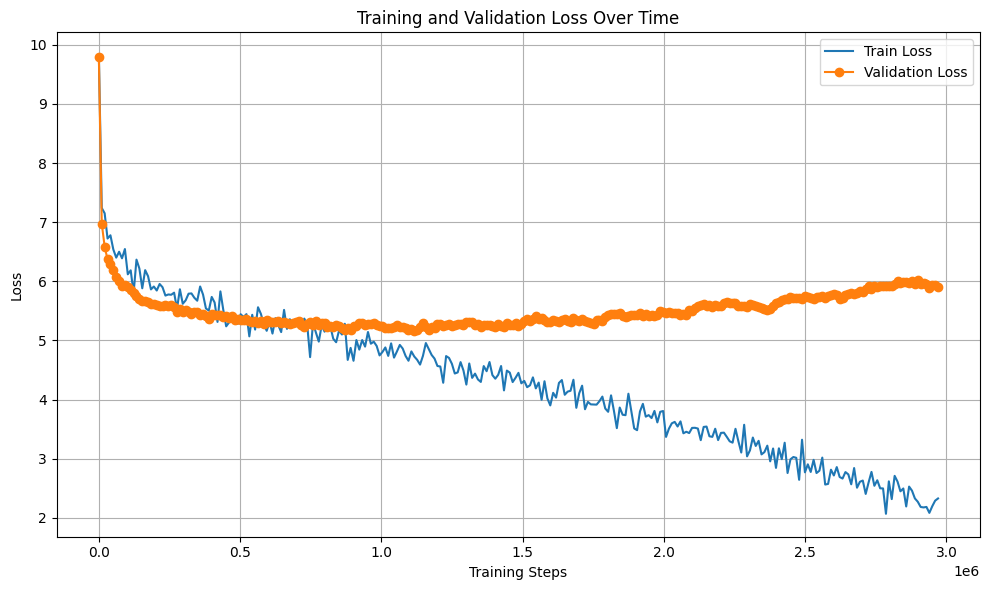

In [22]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses, track_tokens_seen, eval_freq=20):
    # Compute x-axis (training steps)
    steps = list(range(0, eval_freq * len(val_losses), eval_freq))

    plt.figure(figsize=(10, 6))
    #plt.plot(range(len(train_losses)), train_losses, label='Train Loss', alpha=0.7)
    #plt.plot(steps, val_losses, label='Validation Loss', marker='o')
    plt.plot(track_tokens_seen, train_losses, label='Train Loss')
    plt.plot(track_tokens_seen, val_losses, label='Validation Loss', marker='o')

    plt.title("Training and Validation Loss Over Time")
    plt.xlabel("Training Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_losses(train_losses, val_losses, track_tokens_seen, eval_freq=20)


Code to generate text continuation using the trained GPT model.
It tokenizes a prompt, runs autoregressive generation with sampling parameters (temperature, top-k, top-p), stops at the end-of-text token, and decodes the output token IDs back into readable text for display.

In [23]:
tokenizer = tiktoken.get_encoding("gpt2") # Load tokenizer

# Prompt
prompt = "The sky was clear"
token_ids = tokenizer.encode(prompt)
input_ids = torch.tensor([token_ids], dtype=torch.long).to(device)

# Generate
output_ids = model.generate(
    input_ids=input_ids,
    max_new_tokens=50,
    temperature=0.9,
    top_k=40,
    top_p=0.95,
    eos_token_id=tokenizer.eot_token  # or 50256
)

# Decode (tiktoken does not have decode with skip_special_tokens)
output_text = tokenizer.decode(output_ids[0].tolist())
print(output_text)


The sky was clear by no means of singing away from
not been slowly; how he can have gone down in the most athletic
the mouth; but it was, and
apparently hope they seemed as far wound hitherto been freed or malice; yet no longer as


Function to save a custom PyTorch GPT model’s weights and configuration to disk.
It creates a directory (if needed), saves the model’s state dictionary as a .pt file, and writes the model configuration dictionary as a formatted JSON file, enabling easy future loading and reproducibility.

In [24]:
import json
import os

def save_custom_model(model, config, save_dir="custom_gpt_model"):
    """
    Save a custom PyTorch GPT model and its configuration.

    Args:
        model (torch.nn.Module): Your custom GPT model (e.g., GPTModel).
        config (dict): Configuration dictionary used to build the model.
        save_dir (str): Directory to save model files.
    """
    os.makedirs(save_dir, exist_ok=True)
    # Save model weights
    weights_path = os.path.join(save_dir, "model_weights.pt")
    torch.save(model.state_dict(), weights_path)
    
    # Save model config
    config_path = os.path.join(save_dir, "config.json")
    with open(config_path, "w") as f:
        json.dump(config, f, indent=4)
    
    print(f"Model and config saved to: {save_dir}")

save_custom_model(model, GPT_CONFIG_124M, save_dir="saved_gpt")


Model and config saved to: saved_gpt


Function to load a custom PyTorch GPT model from saved files.
It reads the configuration JSON, reconstructs the model instance, loads saved weights, moves the model to the specified device (CPU or GPU), and returns both the model and its config for further use.

In [25]:
def load_custom_model(model_class, save_dir="custom_gpt_model", device="cpu"):
    """
    Load a custom PyTorch GPT model and its weights.

    Args:
        model_class: The class used to define the model (e.g., GPTModel).
        save_dir (str): Directory containing model_weights.pt and config.json.
        device (str): "cpu" or "cuda".

    Returns:
        model (torch.nn.Module): The loaded model.
        config (dict): The configuration used to initialize it.
    """
    # Load config
    config_path = os.path.join(save_dir, "config.json")
    with open(config_path, "r") as f:
        config = json.load(f)
    # Reconstruct model from config
    model = model_class(config)

    # Load weights
    weights_path = os.path.join(save_dir, "model_weights.pt")
    state_dict = torch.load(weights_path, map_location=device)
    model.load_state_dict(state_dict)

    # Move to device
    model.to(device)

    print(f"Model loaded from: {save_dir}")
    return model, config


Code snippet to load the saved custom GPT model onto the available device (GPU if possible, otherwise CPU).
It uses the previously defined load function, then prints the model architecture to confirm successful loading.

In [26]:
# Load your custom GPT model


device = "cuda" if torch.cuda.is_available() else "cpu"
model, config = load_custom_model(GPTModel, save_dir="saved_gpt", device=device)

# Confirm it's working
print(model)


Model loaded from: saved_gpt
GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        

Code to generate text continuation from a loaded GPT model using a new prompt.
It encodes the prompt, generates tokens autoregressively with sampling controls, decodes the output tokens back to text, and prints the result.

In [28]:
tokenizer = tiktoken.get_encoding("gpt2") # Load tokenizer

# Prompt
prompt = "Every journey starts with"
token_ids = tokenizer.encode(prompt)
input_ids = torch.tensor([token_ids], dtype=torch.long).to(device)

# Generate
output_ids = model.generate(
    input_ids=input_ids,
    max_new_tokens=50,
    temperature=0.9,
    top_k=40,
    top_p=0.95,
    eos_token_id=tokenizer.eot_token  # or 50256
)

# Decode (tiktoken does not have decode with skip_special_tokens)
output_text = tokenizer.decode(output_ids[0].tolist())
print(output_text)


Every journey starts with his own
unend, the North; the Captain Ahab and with a hitching hands, when the Virgin, and then the White Whale at his ivory
wholly aspect of an additional blue, literallyage, till
angu, that bro


In [31]:
!python3 -m pip install transformers

  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 54.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.8/558.8 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 64.8 MB/s eta 0:00:00
Using cached filelock-3.18.0-py3-none-any.whl (16 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 57.5 MB/s eta 0:00:00
Using cached idna-3.10-py3-none-any.whl (70 kB)

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip3 install --upgrade pip


In [37]:
import sys
!{sys.executable} -m pip install transformers


  Using cached transformers-4.54.1-py3-none-any.whl.metadata (41 kB)
  Using cached huggingface_hub-0.34.3-py3-none-any.whl.metadata (14 kB)
  Using cached tokenizers-0.21.4-cp39-abi3-macosx_11_0_arm64.whl.metadata (6.7 kB)
  Using cached safetensors-0.5.3-cp38-abi3-macosx_11_0_arm64.whl.metadata (3.8 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached hf_xet-1.1.5-cp37-abi3-macosx_11_0_arm64.whl.metadata (879 bytes)
Using cached transformers-4.54.1-py3-none-any.whl (11.2 MB)
Using cached huggingface_hub-0.34.3-py3-none-any.whl (558 kB)
Using cached safetensors-0.5.3-cp38-abi3-macosx_11_0_arm64.whl (418 kB)
Using cached tokenizers-0.21.4-cp39-abi3-macosx_11_0_arm64.whl (2.7 MB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Using cached hf_xet-1.1.5-cp37-abi3-macosx_11_0_arm64.whl (2.6 MB)

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip3.12 install --upgrade pip


Code to load pretrained weights from the Hugging Face GPT-2 model into a custom GPT implementation.
It defines model configurations for different GPT-2 sizes, initializes a Hugging Face GPT2Model, and copies parameters layer-by-layer—splitting combined QKV weights/biases, transposing where necessary, and assigning them to corresponding custom model attributes with shape checks to ensure compatibility.

In [38]:
import torch
import transformers

from transformers import GPT2Model

# allowed model names
model_names = {
    "gpt2-small (124M)": "openai-community/gpt2",
    "gpt2-medium (355M)": "openai-community/gpt2-medium",
    "gpt2-large (774M)": "openai-community/gpt2-large",
    "gpt2-xl (1558M)": "openai-community/gpt2-xl"
}

CHOOSE_MODEL = "gpt2-small (124M)"

gpt_hf = GPT2Model.from_pretrained(model_names[CHOOSE_MODEL], cache_dir="checkpoints")
gpt_hf.eval()
BASE_CONFIG = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "drop_rate": 0.0,       # Dropout rate
    "qkv_bias": True        # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])
print(BASE_CONFIG)

def assign_check(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(right.clone().detach())

import numpy as np

def load_weights(gpt, gpt_hf):
    d = gpt_hf.state_dict()

    gpt.pos_emb.weight = assign_check(gpt.pos_emb.weight, d["wpe.weight"])
    gpt.tok_emb.weight = assign_check(gpt.tok_emb.weight, d["wte.weight"])
    
    for b in range(BASE_CONFIG["n_layers"]):
        q_w, k_w, v_w = np.split(d[f"h.{b}.attn.c_attn.weight"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign_check(gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign_check(gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign_check(gpt.trf_blocks[b].att.W_value.weight, v_w.T)
        q_b, k_b, v_b = np.split(d[f"h.{b}.attn.c_attn.bias"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign_check(gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign_check(gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign_check(gpt.trf_blocks[b].att.W_value.bias, v_b)
    
        gpt.trf_blocks[b].att.out_proj.weight = assign_check(gpt.trf_blocks[b].att.out_proj.weight, d[f"h.{b}.attn.c_proj.weight"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign_check(gpt.trf_blocks[b].att.out_proj.bias, d[f"h.{b}.attn.c_proj.bias"])
    
        gpt.trf_blocks[b].ff.layers[0].weight = assign_check(gpt.trf_blocks[b].ff.layers[0].weight, d[f"h.{b}.mlp.c_fc.weight"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign_check(gpt.trf_blocks[b].ff.layers[0].bias, d[f"h.{b}.mlp.c_fc.bias"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign_check(gpt.trf_blocks[b].ff.layers[2].weight, d[f"h.{b}.mlp.c_proj.weight"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign_check(gpt.trf_blocks[b].ff.layers[2].bias, d[f"h.{b}.mlp.c_proj.bias"])
        gpt.trf_blocks[b].norm1.scale = assign_check(gpt.trf_blocks[b].norm1.scale, d[f"h.{b}.ln_1.weight"])
        gpt.trf_blocks[b].norm1.shift = assign_check(gpt.trf_blocks[b].norm1.shift, d[f"h.{b}.ln_1.bias"])
        gpt.trf_blocks[b].norm2.scale = assign_check(gpt.trf_blocks[b].norm2.scale, d[f"h.{b}.ln_2.weight"])
        gpt.trf_blocks[b].norm2.shift = assign_check(gpt.trf_blocks[b].norm2.shift, d[f"h.{b}.ln_2.bias"])
    
        gpt.final_norm.scale = assign_check(gpt.final_norm.scale, d[f"ln_f.weight"])
        gpt.final_norm.shift = assign_check(gpt.final_norm.shift, d[f"ln_f.bias"])
        gpt.out_head.weight = assign_check(gpt.out_head.weight, d["wte.weight"])


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'vocab_size': 50257, 'context_length': 1024, 'drop_rate': 0.0, 'qkv_bias': True, 'emb_dim': 768, 'n_layers': 12, 'n_heads': 12}


Code to instantiate the custom GPT model with the loaded HF weights and move it to the appropriate device (GPU if available).
Also includes utility functions to encode text into token ID tensors with batch dimension and decode token ID tensors back into text using the GPT-2 tokenizer.

In [39]:
gpt = GPTModel(BASE_CONFIG)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_weights(gpt, gpt_hf)
gpt.to(device)

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text)
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)  # remove batch dimension
    return tokenizer.decode(flat.tolist())


Code to generate text using the custom GPT model loaded with pretrained weights.
It encodes a prompt, generates up to 150 new tokens with sampling options (temperature, top-k, top-p), stops at the end-of-text token, then decodes and prints the generated text.

In [41]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

prompt = "The sky was clear"

token_ids = tokenizer.encode(prompt)
input_ids = torch.tensor([token_ids], dtype=torch.long).to(device)

output_ids = gpt.generate(
    input_ids=input_ids,
    max_new_tokens=150,
    temperature=0.9,
    top_k=40,
    top_p=0.95,
    eos_token_id=tokenizer.eot_token  # or 50256
)

# Decode (tiktoken does not have decode with skip_special_tokens)
output_text = tokenizer.decode(output_ids[0].tolist())
print(output_text)


The sky was clear and beautiful. The day was filled with bright stars, and the clouds were as bright as the sun. As the stars slowly came out of the clouds, they were bright and bright. When they turned and set, the sky became dim.

Even when the sun shone out through the clouds, the sky was not beautiful. Even at the end of the day, they were beautiful.

When the day was over, all of the people who were present were satisfied with the night, even if they were not able to see the night at all.

In the morning, when the sun became a perfect blue, the sky became beautiful, even if you couldn't see it.

After the sun had passed by, the sky


# Summary

## Outputs from Models

**Output from my trained GPT model:**

> The sky was clear by no means of singing away from not been slowly; how he can have gone down in the most athletic the mouth; but it was, and apparently hope they seemed as far wound hitherto been freed or malice; yet no longer as

**Output from the pretrained GPT-2 small model:**

> The sky was clear and beautiful. The day was filled with bright stars, and the clouds were as bright as the sun. As the stars slowly came out of the clouds, they were bright and bright. When they turned and set, the sky became dim. Even when the sun shone out through the clouds, the sky was not beautiful. Even at the end of the day, they were beautiful. When the day was over, all of the people who were present were satisfied with the night, even if they were not able to see the night at all. In the morning, when the sun became a perfect blue, the sky became beautiful, even if you couldn't see it. After the sun had passed by, the sky.

## Analysis and Comparison

The text generated by **my trained model** is somewhat rough and doesn’t flow very well. Sentences feel broken or disconnected, and some parts lack clear meaning. This shows the model is still learning language patterns but hasn’t fully mastered them yet.

In contrast, the **pretrained GPT-2 model** produces smooth, well-formed sentences. Its output is easy to read and paints a vivid picture of the sky. The sentences flow logically with richer vocabulary, making the text sound more natural and engaging.

The main reason for this difference is likely because my model was trained on a smaller dataset and fewer epochs, so it hasn’t fully captured the nuances of language. The pretrained GPT-2 model has been trained on a much larger corpus and for longer, resulting in a better grasp of grammar, context, and style.

Overall, my model is a promising start demonstrating the core GPT concepts, but the pretrained GPT-2 is noticeably more polished and capable of generating meaningful and coherent text.